# Step 1 – Data Pre-processing and management:

## Generate a spectrogram from a file
Do imports first

In [2]:
#import matplotlib
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm
# to enable zooming in matplotlib in notebook
#%matplotlib notebook
#conda install -c conda-forge ipympl # or pip install ipympl #This is to allow zooming in the notebook
#matplotlib ipympl
import tensorflow as tf     #pip install tensorflow
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

## Call Type : RUPE B

Name audio and annotation file that you want to import (without the extensions), then read in the audio and annotations

In [4]:
#File index
file =  '5713.210809120002'  #from PPT at time 892-896 (Rupe B)
#file = 'Rupes A and B\\5713.210809120002'  #from PPT at time 892-896 (Rupe B)
#file = 'Guttural rupe\\5711.211013040024'
#file = 'Rupes A and B\\5713.210825190002'
#file =          'Moan\\5713.210902110002'  #from PPT at time 212 seconds

#Read the 2 files
sample_rate, samples = wavfile.read(file+'.wav')
annot_file_path = file +'.Table.1.selections.txt'

#Read the file into a DataFrame
df = pd.read_csv(file +'.Table.1.selections.txt', sep='\t')

#Display the first few rows of the DataFrame
#print(df.head())
print(df)

    Selection           View  Channel  Begin Time (s)  End Time (s)  \
0           1  Spectrogram 1        1      871.984579    872.045877   
1           2  Spectrogram 1        1      872.605082    872.730809   
2           3  Spectrogram 1        1      873.525329    873.616653   
3           4  Spectrogram 1        1      874.776471    874.904325   
4           5  Spectrogram 1        1      876.693356    876.876005   
5           6  Spectrogram 1        1      877.095183    877.364589   
6           7  Spectrogram 1        1      884.521098    884.664983   
7           8  Spectrogram 1        1      887.606950    887.981380   
8           9  Spectrogram 1        1      891.800005    892.179001   
9          10  Spectrogram 1        1      892.539731    893.119640   
10         11  Spectrogram 1        1      893.553430    893.927859   
11         12  Spectrogram 1        1      894.343384    894.576261   
12         13  Spectrogram 1        1      895.302288    895.768042   
13    

### Calculate the Spectrogram

In [11]:
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate, nperseg=2456, nfft=4096, noverlap=1228, window='hann')       #Try nfft=8192 if computer permits

In [ ]:
#fmax = max(df['High Freq (Hz)'])
#fmax

In [ ]:
#fmin = min(df['Low Freq (Hz)'])
#fmin

In [ ]:
#time = df['End Time (s)'] - df['Begin Time (s)']
#max_time = max(time)
#max_time

With the resultsing spectrogram, trim all the tiny values so that log scale displays correctly. Also, all of the relevant info is below 1KHz so trim the data to only display sub 1-KHz frequencies

In [ ]:
spectrogram[spectrogram < 0.001] = 0.001    #Trim off all the tiny values so that log scale displays correctly

#Trim in frequency
fmin = 20 # Hz
fmax = 1000 # Hz
freq_slice = np.where((frequencies >= fmin) & (frequencies <= fmax))

#keep only frequencies of interest
frequencies = frequencies[freq_slice]
spectrogram = spectrogram[freq_slice,:][0]

Next I'm going to define a function that will overlay the annotated rectangles onto the spectrogram (different colours for each call)

In [437]:
def overlay_annotations(ax, df, annotation_colors):
    #Track labels to ensure they are added only once in the legend
    added_labels = set()

    for _, row in df.iterrows():
        start_time = row['Begin Time (s)']
        end_time = row['End Time (s)']
        low_freq = row['Low Freq (Hz)']
        high_freq = row['High Freq (Hz)']
        annotation = row['Annotation']

        #Skip if the annotation is not in the defined colors
        if annotation not in annotation_colors:
            continue

        #Draw rectangles
        ax.add_patch(
            plt.Rectangle(
                (start_time, low_freq),  #Bottom Left corner
                end_time - start_time,  #Width (time)
                high_freq - low_freq,  #Height (frequency)
                edgecolor=annotation_colors[annotation],
                facecolor='none',
                linewidth=2,
                label=annotation if annotation not in added_labels else None  #Add label once
            )
        )
        added_labels.add(annotation)  #Mark label as added

    ax.legend(loc='upper right')     #Add legend

I've also written a function below that updates the colormap when you zoom in on a particular region - so that the max and min values are always visible

In [438]:
def update_colormap(event):
    #Get current view limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    #Find indices corresponding to the current view limits
    x_indices = np.where((times >= xlim[0]) & (times <= xlim[1]))[0]
    y_indices = np.where((frequencies >= ylim[0]) & (frequencies <= ylim[1]))[0]

    #Handle cases where no data is visible
    if len(x_indices) == 0 or len(y_indices) == 0:
        return

    #Extract the visible data
    data_visible = spectrogram[np.ix_(y_indices, x_indices)]
    #data_visible = np.log(spectrogram)[np.ix_(y_indices, x_indices)]

    #Compute new color limits
    vmin = np.nanmin(data_visible)
    vmax = np.nanmax(data_visible)

    #Update the color limits of the pcolormesh
    pc.set_clim(vmin=vmin, vmax=vmax)

    #Update the colorbar to reflect the new color limits
    cbar.update_normal(pc)

    #Redraw the figure
    plt.draw()


Ok, let's plot the spectrogram and annotations

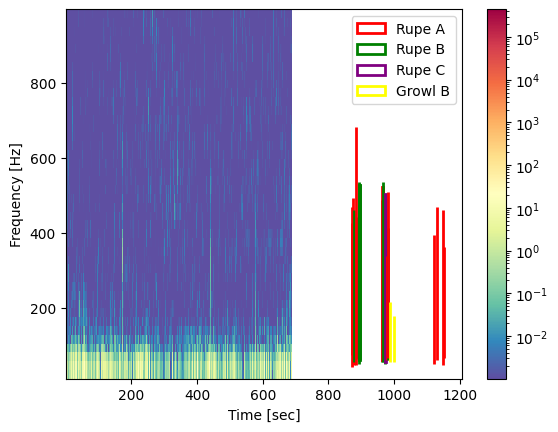

In [439]:
#Define colors for annotations
annotation_colors = {
    "Rupe A": "red",
    "Rupe B": "green",
    "Growl B": "yellow",
    "Rupe C" : "purple",
    "Moan": "pink",
    "G rupe" : "blue"
}

pc = plt.pcolormesh(times, frequencies, spectrogram, norm=LogNorm(), cmap='Spectral_r')
#pc = plt.pcolormesh(times, frequencies, np.log(spectrogram))
cbar = plt.colorbar(pc)
#plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

#Get the current axes
ax = plt.gca()
overlay_annotations(ax, df, annotation_colors)

#Connect the update function to the axes limit change events
ax.callbacks.connect('xlim_changed', update_colormap)
ax.callbacks.connect('ylim_changed', update_colormap)

plt.show()

Note : As you can see in the spectogram above for file 5713.210809120002, there are no calls between 400 seconds and 800 seconds.

Extract out a portion of interest from the spectrogram when you can hear a RUPE B call

I'm going to extract a single call now and check the size of the spectrogram array

In [13]:
df['Spectogram'] = None
#print(df.head())

In [449]:
for index, row in df.iterrows():
    start_time = row['Begin Time (s)']
    end_time = row['End Time (s)']
    low_freq = row['Low Freq (Hz)']
    high_freq = row['High Freq (Hz)']
    annotation = row['Annotation']
    time_indices = np.where((times >= start_time) & (times <= end_time))[0]

    #Find indices for the frequency range
    freq_indices = np.where((frequencies >= low_freq) & (frequencies <= high_freq))[0]

    #Extract the portion of the spectrogram
    spectrogram_sub = spectrogram[freq_indices][:, time_indices]
    frequencies_sub = frequencies[freq_indices]
    times_sub = times[time_indices]
    print(spectrogram_sub.shape)
    df['Spectogram'][index] = spectrogram_sub
    np.savez('./rupe_b_%i' %index, spectrogram_sub)



(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)


In [450]:
df.Spectogram[1]

array([], shape=(28, 0), dtype=float32)

Try and save the spectrogram plot. (I wouldn't actually do this in practice - I would save the extracted spectrogram as raw data to be used for ML)

## Call Type : No Call

As you can see in the spectogram above for file 5713.210809120002, there are no calls between 875.0 seconds and 876.5 seconds.
Lets do a spectogram of a no call between 400.5 seconds and 401.2 seconds

In [459]:
df['No Call Spectogram'] = None
#print(df.head())

In [460]:
for index, row in df.iterrows():
    #print(index)
    #df[]
    if index == max(df.index):
        quit
    else:
        print((df['Begin Time (s)'][index+1])-(df['End Time (s)'][index]))
        time_end = df['Begin Time (s)'][index+1]
        time_start = df['End Time (s)'][index]
        #no_call_time = start_time - end_time
        low_freq = fmin
        high_freq = fmax
        #annotation = 'no call'
        time_indices = np.where((times >= time_start) & (times <= time_end))[0]

        #Find indices for the frequency range
        freq_indices = np.where((frequencies >= low_freq) & (frequencies <= high_freq))[0]

        #Extract the portion of the spectrogram
        spectrogram_sub = spectrogram[freq_indices][:, time_indices]
        #frequencies_sub = frequencies[freq_indices]
        times_sub = times[time_indices]
        #print(spectrogram_sub.shape)
        df['No Call Spectogram'][index] = spectrogram_sub
        np.savez('./no_call_%i' %index, spectrogram_sub)
        #print(no_call_time)

0.5592054569999618
0.7945205480000368
1.1598173520000046
1.7890316670000175
0.2191780819999849
7.156509231999962
2.941967106999982
3.818625763
0.36073059400007423
0.43378995399996256
0.41552511399993364
0.7260273970000526
66.96830468600001
0.3470319630000631
0.6073059359999888
1.1415525109999862
5.995714366000016
0.6324611539999978
5.443588243000022
0.3972602740000184
1.6894977169999947
4.797847301999923
11.279008129999966
122.06893445000003
10.641757910000024
18.22803683500001
0.22831050200011305
-265.451105955


In [5]:
row_df = pd.DataFrame(columns=df.columns)
row_df

,Selection,View,Channel,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS/Hz),Annotation


In [6]:
insert_loc=0
for index, row in df.iterrows():
    #print(index)
    #df[]
    if index == (max(df.index)):
        quit
    #elif index % 2 != 0:
        #continue
    else:
        #print((df['Begin Time (s)'][index+1])-(df['End Time (s)'][index]))
        #no_call_time = start_time - end_time
        #low_freq = min_frequency
        #high_freq = max_frequency
        #annotation = 'no call'
        #time_indices = np.where((times >= time_start) & (times <= time_end))[0]

        #Find indices for the frequency range
        #freq_indices = np.where((frequencies >= low_freq) & (frequencies <= high_freq))[0]

        #Extract the portion of the spectrogram
        #spectrogram_sub = spectrogram[freq_indices][:, time_indices]
        #frequencies_sub = frequencies[freq_indices]
        #times_sub = times[time_indices]
        #print(spectrogram_sub.shape)
        #df.loc[index] = df[{Annotation:'No Call'}]
        #print(time_start, time_end)
        time_end = df['Begin Time (s)'][index+1]
        time_start = df['End Time (s)'][index]
        row=["","","",time_start,time_end,"","","","","","No Call"]
        #row=pd.Series(row)
        #row_df = pd.DataFrame([row],columns=df.columns)
        #insert_loc = df.index.max()
        row_df.loc[index] = row
        #df.loc[index+1] = df.loc[index+2]
        #df.loc[index+1] = row
        #df = df.sort_index()
        #df = df.reset_index(drop = True)
        #df.index = range(len(df))
        #df = df.sort_index()
        #df = df.append(pd.DataFrame(row,ignore_index=True))
        #df.index = (df.index + 1) % len(df)
        #df = df.sort_index()
        #a_row = pd.Series(row)
        #row_df = pd.DataFrame(row,columns=df.columns)
        #row_df = pd.concat([row_df, row], ignore_index=True)
        #df = pd.concat([pd.DataFrame([row],columns=df.columns),df],ignore_index=False)

In [7]:
df = pd.concat([df, row_df], ignore_index=True)
df = df.sort_values(by=['Begin Time (s)'])
df = df.reset_index(drop = True)
df

,Selection,View,Channel,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS/Hz),Annotation
0,1,Spectrogram 1,1,871.984579,872.045877,75.224,426.862,0.0613,351.638,-97.26,Rupe A
1,,,,872.045877,872.605082,,,,,,No Call
2,2,Spectrogram 1,1,872.605082,872.730809,42.314,470.151,0.1257,427.837,-84.86,Rupe A
3,,,,872.730809,873.525329,,,,,,No Call
4,3,Spectrogram 1,1,873.525329,873.616653,65.821,493.658,0.0913,427.837,-90.74,Rupe A
5,,,,873.616653,874.776471,,,,,,No Call
6,4,Spectrogram 1,1,874.776471,874.904325,70.523,441.942,0.1279,371.419,-91.9,Rupe A
7,,,,874.904325,876.693356,,,,,,No Call
8,5,Spectrogram 1,1,876.693356,876.876005,47.015,413.733,0.1826,366.718,-90.45,Rupe A
9,,,,876.876005,877.095183,,,,,,No Call


In [8]:
df = df.drop(df[df.Annotation == 'Rupe A'].index)
df = df.sort_values(by=['Begin Time (s)'])
df = df.reset_index(drop = True)
df

,Selection,View,Channel,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS/Hz),Annotation
0,,,,872.045877,872.605082,,,,,,No Call
1,,,,872.730809,873.525329,,,,,,No Call
2,,,,873.616653,874.776471,,,,,,No Call
3,,,,874.904325,876.693356,,,,,,No Call
4,,,,876.876005,877.095183,,,,,,No Call
5,6,Spectrogram 1,1,877.095183,877.364589,56.418,460.748,0.2694,404.33,-89.1,Rupe B
6,,,,877.364589,884.521098,,,,,,No Call
7,,,,884.664983,887.606950,,,,,,No Call
8,8,Spectrogram 1,1,887.606950,887.981380,65.821,441.942,0.3744,376.121,-86.11,Rupe B
9,,,,887.981380,891.800005,,,,,,No Call


In [14]:
for index, row in df.iterrows():
  if df.Annotation[index] == 'Rupe B':
    start_time = row['Begin Time (s)']
    end_time = row['End Time (s)']
    low_freq = row['Low Freq (Hz)']
    high_freq = row['High Freq (Hz)']
    annotation = row['Annotation']
    time_indices = np.where((times >= start_time) & (times <= end_time))[0]
  else:
    start_time = row['Begin Time (s)']
    end_time = row['End Time (s)']
    #low_freq = df['Low Freq (Hz)'].mean()
    low_freq = 42
    #high_freq = df['High Freq (Hz)'].mean()
    high_freq = 650
    annotation = row['Annotation']
    time_indices = np.where((times >= start_time) & (times <= end_time))[0]


    #Find indices for the frequency range
    freq_indices = np.where((frequencies >= low_freq) & (frequencies <= high_freq))[0]

    #Extract the portion of the spectrogram
    spectrogram_sub = spectrogram[freq_indices][:, time_indices]
    frequencies_sub = frequencies[freq_indices]
    times_sub = times[time_indices]
    print(spectrogram_sub.shape)
    df['Spectogram'][index] = spectrogram_sub
    np.savez('./rupe_b_no_call%i' %index, spectrogram_sub)

(26, 0)
(26, 0)
(26, 0)
(26, 0)
(26, 0)
(26, 0)
(26, 0)
(26, 0)
(26, 0)
(26, 0)
(26, 0)
(26, 0)
(26, 0)
(26, 0)
(26, 0)
(26, 0)
(26, 0)
(26, 0)
(26, 0)
(26, 0)
(26, 0)
(26, 0)
(26, 0)
(26, 0)
(26, 0)
(26, 0)
(26, 0)
(26, 0)
(26, 0)
(26, 0)
(26, 0)


### TRAIN TEST SPLIT

In [461]:
#X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1138)

In [462]:
X = spectrogram_sub[0:29]
y = df.Annotation[0:29]
#y = df.Annotation[0:42]
#y = df.Annotation
# Instead of selecting the first element of 'Annotation', use a label for the single sample
#y = np.array([df.Annotation[0]])  # Assuming you want to use the first annotation as the label
#Reshape X before train_test_split to add a sample dimension
#X = X.reshape(25, spectrogram_sub.shape[25], spectrogram_sub.shape[55])  # Reshape to (samples, 25, 55)

# Reshape X to have the correct number of samples
# Assuming you have 25 samples, each with 25x55 features
# If the number of samples is different, adjust the first dimension accordingly
#X = X.reshape(1, spectrogram_sub.shape[0], spectrogram_sub.shape[1])

#Now proceed with the train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1138)

print(y)
numberofclasses = np.unique(y).size
print("numberofclasses: ", numberofclasses)

0      Rupe A
1      Rupe A
2      Rupe A
3      Rupe A
4      Rupe A
5      Rupe B
6      Rupe A
7      Rupe B
8      Rupe B
9      Rupe B
10     Rupe B
11     Rupe B
12     Rupe B
13     Rupe B
14     Rupe B
15     Rupe A
16     Rupe B
17     Rupe B
18     Rupe C
19     Rupe A
20     Rupe B
21     Rupe A
22    Growl B
23    Growl B
24     Rupe A
25     Rupe A
26     Rupe A
27     Rupe A
28     Rupe A
Name: Annotation, dtype: object
numberofclasses:  4


### SEQUENTIAL TENSOR FLOW KERAS MODEL

In [463]:
model = tf.keras.models.Sequential()
#model.add(tf.keras.layers.Flatten(input_shape=(25, 0)))
model.add(tf.keras.layers.Dense(100,activation='relu'))
model.add(tf.keras.layers.Dense(100,activation='relu'))
model.add(tf.keras.layers.Dense(100,activation='relu'))
model.add(tf.keras.layers.Dense(numberofclasses))

In [464]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### COMPILE MODEL

In [465]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [466]:
# Get all unique labels from both y_train and y_test
# Convert y_test to a NumPy array to avoid potential issues with Pandas Series
y_test_array = y_test.to_numpy()

# Get all unique labels from both y_train and y_test
#all_labels = np.unique(np.concatenate((y_train, y_test_array)))

#Instead of using np.concatenate, get unique labels separately and then combine them
unique_train_labels = np.unique(y_train) # Get unique numerical labels from y_train
unique_test_labels = np.unique(y_test_array) # Get unique string labels from y_test_array

# Combine the unique labels
all_labels = np.union1d(unique_train_labels, unique_test_labels) # Use union1d to combine unique values from both arrays

# Fit the LabelEncoder on all unique labels
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

#label_encoder = LabelEncoder()
y_train = label_encoder.transform(y_train)
#y_test = label_encoder.transform(y_test)

# Transform y_test using the fitted LabelEncoder
y_test = label_encoder.transform(y_test_array)

### FIT MODEL

In [467]:
history = model.fit(X_train, y_train, epochs=30, validation_split=0.2)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - loss: 1.3863 - val_accuracy: 0.4000 - val_loss: 1.3857
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5000 - loss: 1.3853 - val_accuracy: 0.4000 - val_loss: 1.3851
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.5000 - loss: 1.3843 - val_accuracy: 0.4000 - val_loss: 1.3845
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5000 - loss: 1.3833 - val_accuracy: 0.4000 - val_loss: 1.3839
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5000 - loss: 1.3823 - val_accuracy: 0.4000 - val_loss: 1.3833
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5000 - loss: 1.3813 - val_accuracy: 0.4000 - val_loss: 1.3827
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5000 - loss: 1.3803 - val_accuracy: 0.4000 - val_loss: 1.3821
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5000 - loss: 1.3793 - val_accuracy: 0.4000 - val_loss: 1.3

In [468]:
#plt.imshow(spectrogram_sub)

In [469]:
X_test

array([], shape=(8, 0), dtype=float32)

In [470]:
y_pred = model.predict(X_test)
#y_pred[6].max()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


In [471]:
y_test

array([2, 2, 3, 1, 1, 0, 1, 1])

### MODEL ACCURACY

In [472]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)

1/1 - 0s - 33ms/step - accuracy: 0.5000 - loss: 1.3718


In [473]:
print("Model accuracy = ", accuracy)

Model accuracy =  0.5


### Training and Validation Loss

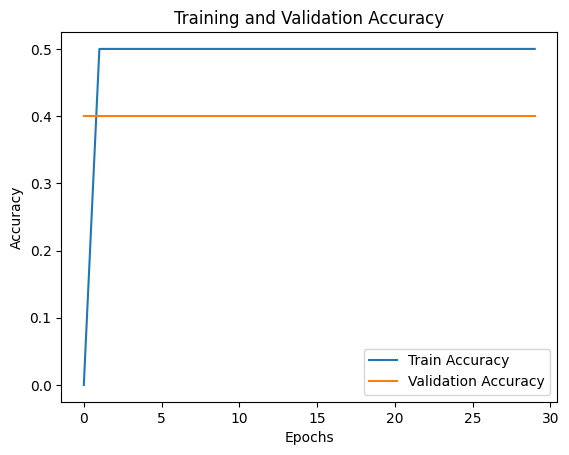

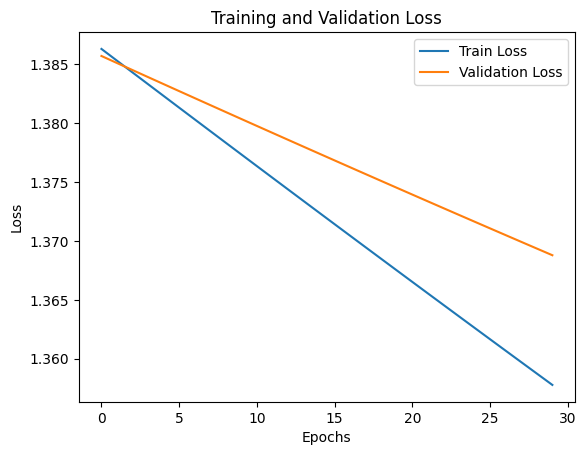

In [474]:
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

## Call Type : Moan

In [ ]:
#File index
#file =  '5713.210809120002'  #from PPT at time 892-896 (Rupe B)
#file =  'Rupes A and B\\5713.210809120002'  #from PPT at time 892-896 (Rupe B)
#file = '5711.211013050024'
#file = 'Rupes A and B\\5713.210825190002'
#file =          'Moan\\5713.210902110002'  #from PPT at time 212 seconds
file = '5713.210902110002'  #from PPT at time 212 seconds

#Read the 2 files
sample_rate, samples = wavfile.read(file+'.wav')
annot_file_path = file +'.Table.1.selections.txt'

#Read the file into a DataFrame
df = pd.read_csv(file +'.Table.1.selections.txt', sep='\t')

#Display the first few rows of the DataFrame
print(df.head())

   Selection           View  Channel  Begin Time (s)  End Time (s)  \
0          1  Spectrogram 1        1      139.054770    139.162684   
1          2  Spectrogram 1        1      136.424374    136.953197   
2          3  Spectrogram 1        1      141.637244    142.016354   
3          4  Spectrogram 1        1      176.545924    176.796172   
4          5  Spectrogram 1        1      210.555520    211.194789   

   Low Freq (Hz)  High Freq (Hz)  Delta Time (s)  Delta Freq (Hz)  \
0         93.085         787.149          0.1079          694.064   
1         84.337         437.751          0.5288          353.414   
2        175.202         363.881          0.3791          188.679   
3        164.474         323.450          0.2502          158.976   
4        131.579         485.175          0.6393          353.596   

   Avg Power Density (dB FS/Hz) Annotation  
0                        -89.96   Type 4 A  
1                        -86.62     Rupe C  
2                        -89.

In [ ]:
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate, nperseg=2456, nfft=4096, noverlap=1228, window='hann')       #Try nfft=8192 if computer permits

In [ ]:
spectrogram[spectrogram < 0.001] = 0.001    #Trim off all the tiny values so that log scale displays correctly

#Trim in frequency
fmin = 20 # Hz
fmax = 1000 # Hz
freq_slice = np.where((frequencies >= fmin) & (frequencies <= fmax))

#keep only frequencies of interest
frequencies = frequencies[freq_slice]
spectrogram = spectrogram[freq_slice,:][0]

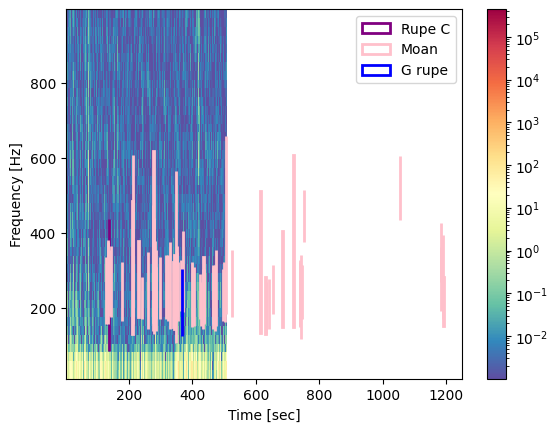

In [ ]:
#Define colors for annotations
annotation_colors = {
    "Rupe A": "red",
    "Rupe B": "green",
    "Growl B": "yellow",
    "Rupe C" : "purple",
    "Moan": "pink",
    "G rupe" : "blue"
}

pc = plt.pcolormesh(times, frequencies, spectrogram, norm=LogNorm(), cmap='Spectral_r')
#pc = plt.pcolormesh(times, frequencies, np.log(spectrogram))
cbar = plt.colorbar(pc)
#plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

#Get the current axes
ax = plt.gca()
overlay_annotations(ax, df, annotation_colors)

#Connect the update function to the axes limit change events
ax.callbacks.connect('xlim_changed', update_colormap)
ax.callbacks.connect('ylim_changed', update_colormap)

plt.show()

(42, 0)


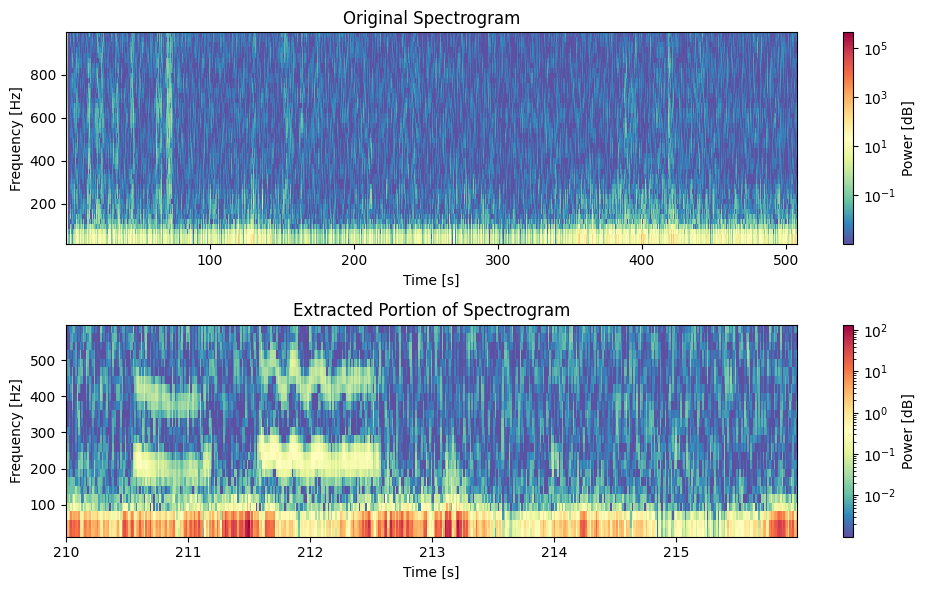

In [ ]:
#Define time and frequency limits
time_start, time_end = 210, 216  # Time range in seconds
freq_start, freq_end = 20, 600  # Frequency range in Hz

#Find indices for the time range
#time_indices = np.where((times >= time_start) & (times <= time_end))[0]

# Find the closest time indices to the desired range if no exact match is found
time_indices = np.where(np.logical_and(times >= time_start, times <= time_end))[0]
if len(time_indices) == 0:
    closest_start_index = np.argmin(np.abs(times - time_start))
    closest_end_index = np.argmin(np.abs(times - time_end))
    time_indices = np.arange(closest_start_index, closest_end_index + 1)

#Find indices for the frequency range
freq_indices = np.where((frequencies >= freq_start) & (frequencies <= freq_end))[0]

#Extract the portion of the spectrogram
spectrogram_sub_moan = spectrogram[freq_indices][:, time_indices]
frequencies_sub = frequencies[freq_indices]
times_sub = times[time_indices]
print(spectrogram_sub.shape)

#Plot the original and sub-portion spectrograms
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.pcolormesh(times, frequencies, spectrogram, norm=LogNorm(), cmap='Spectral_r')
plt.title('Original Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.subplot(2, 1, 2)
plt.pcolormesh(times_sub, frequencies_sub, spectrogram_sub_moan, norm=LogNorm(), cmap='Spectral_r')
plt.title('Extracted Portion of Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.tight_layout()
plt.show()


In [ ]:
spectrogram_sub_moan.shape

(25, 469)

Spectrogram size:  (26, 78)


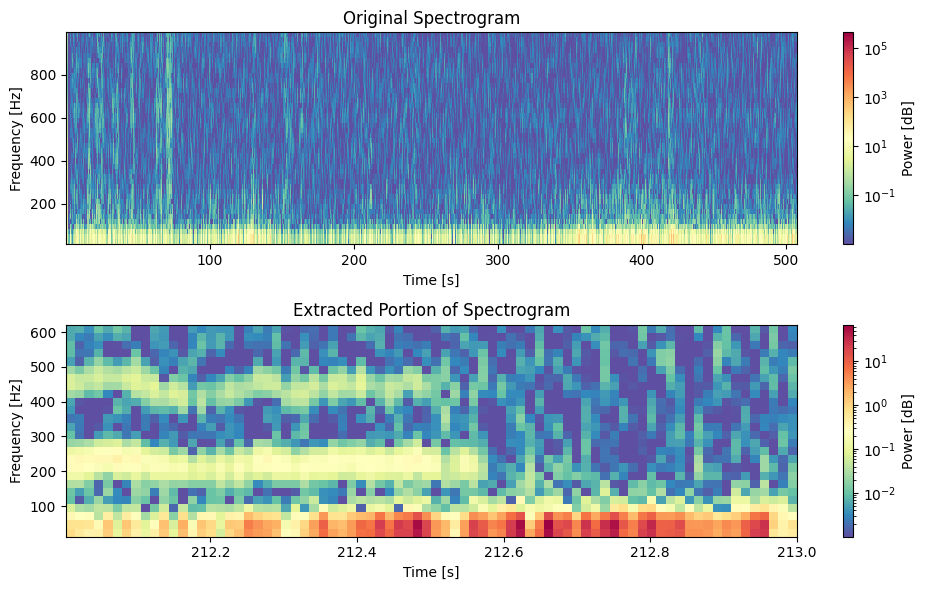

In [ ]:
#Define time and frequency limits
time_start, time_end = 212.0, 213.0  # Time range in seconds
freq_start, freq_end = 20, 620  # Frequency range in Hz

#Find indices for the time range
#time_indices = np.where((times >= time_start) & (times <= time_end))[0]

# Find the closest time indices to the desired range if no exact match is found
time_indices = np.where(np.logical_and(times >= time_start, times <= time_end))[0]
if len(time_indices) == 0:
    closest_start_index = np.argmin(np.abs(times - time_start))
    closest_end_index = np.argmin(np.abs(times - time_end))
    time_indices = np.arange(closest_start_index, closest_end_index + 1)

#Find indices for the frequency range
freq_indices = np.where((frequencies >= freq_start) & (frequencies <= freq_end))[0]

#Extract the portion of the spectrogram
spectrogram_sub_moan = spectrogram[freq_indices][:, time_indices]
frequencies_sub = frequencies[freq_indices]
times_sub = times[time_indices]
print("Spectrogram size: ", spectrogram_sub_moan.shape)

#Plot the original and sub-portion spectrograms
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.pcolormesh(times, frequencies, spectrogram, norm=LogNorm(), cmap='Spectral_r')
plt.title('Original Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.subplot(2, 1, 2)
plt.pcolormesh(times_sub, frequencies_sub, spectrogram_sub_moan, norm=LogNorm(), cmap='Spectral_r')
plt.title('Extracted Portion of Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.tight_layout()
plt.show()